# Predicting the Stock Market

In this project, I will work with data from the S&P500 Index. The S&P500 is a stock market index. I'll be using historical data on the price of the S&P500 Index to make predictions about future prices. Predicting whether an index will go up or down will help us forecast how the stock market as a whole will perform. Since stocks tend to correlate with how well the economy as a whole is performing, it can also help us make economic forecasts.

In this mission, I'll be working with a csv file containing index prices. Each row in the file contains a daily record of the price of the S&P500 Index from 1950 to 2015. The dataset is stored in sphist.csv.

The columns of the dataset are:

- Date -- The date of the record.
- Open -- The opening price of the day (when trading starts).
- High -- The highest trade price during the day.
- Low -- The lowest trade price during the day.
- Close -- The closing price for the day (when trading is finished).
- Volume -- The number of shares traded.
- Adj Close -- The daily closing price, adjusted retroactively to include any corporate actions. Read more here.

I'll be using this dataset to develop a predictive model. I'll train the model with data from 1950-2012, and try to make predictions from 2013-2015.


In [124]:
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [94]:
data = pd.read_csv('sphist.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


### Feature Transformation

In [95]:
# Change "Date" column to Pandas Date type which will allow for date comprison with the column
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
Date         16590 non-null datetime64[ns]
Open         16590 non-null float64
High         16590 non-null float64
Low          16590 non-null float64
Close        16590 non-null float64
Volume       16590 non-null float64
Adj Close    16590 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 907.3 KB


In [96]:
# Sort dataframe by "Date" ascendingly for later steps
data = data.sort_values('Date', ascending=True)
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


In [97]:
data.tail()

,Date,Open,High,Low,Close,Volume,Adj Close
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068


Stock market data is sequential, and each observation comes a day after the previous observation. Thus, the observations are not all independent, and you can't treat them as such.

This means you have to be extra careful to not inject "future" knowledge into past rows when you do training and prediction. Injecting future knowledge will make our model look good when you're training and testing it, but will make it fail in the real world.

The time series nature of the data means that can generate indicators to make our model more accurate.  When you do this, you have to be careful not to use the current row in the values you average. You want to teach the model how to predict the current price from historical prices. If you include the current price in the prices you average, it will be equivalent to handing the answers to the model upfront, and will make it impossible to use in the "real world", where you don't know the price upfront.

Indicators to be deployed:
- The average price from the past 5 days.
- The average price for the past 50 days.
- The average price for the past 200 days.
- The ratio between the average price for the past 5 days, and the average price for the past 200 days.
- The standard deviation of the price over the past 5 days.
- The standard deviation of the price over the past 50 days.
- The ratio between the standard deviation for the past 5 days, and the standard deviation for the past 50 days.

"Days" means "trading days"

In [98]:
data['avg_day_10'] = data['Close'].rolling(window=10).mean().shift(1)
data['std_day_10'] = data['Close'].rolling(window=10).std().shift(1)
data.head(20)

,Date,Open,High,Low,Close,Volume,Adj Close,avg_day_10,std_day_10
16589,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,NaN,NaN
16588,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,NaN,NaN
16587,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,NaN,NaN
16586,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,NaN,NaN
16585,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,NaN,NaN
16584,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,NaN,NaN
16583,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,NaN,NaN
16582,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,NaN,NaN
16581,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,NaN,NaN
16580,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,NaN,NaN


In [99]:
data['avg_day_50'] = data['Close'].rolling(window=50).mean().shift(1)
data['std_day_50'] = data['Close'].rolling(window=50).std().shift(1)
data.tail()

,Date,Open,High,Low,Close,Volume,Adj Close,avg_day_10,std_day_10,avg_day_50,std_day_50
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2079.273999,14.883905,2031.122996,63.216429
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2084.217993,13.393465,2033.836194,63.317967
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2087.125000,6.759073,2036.571594,62.247456
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2083.729004,13.702747,2038.788796,60.646163
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,2084.773999,13.889039,2041.977795,59.101659


In [100]:
data['avg_day_200'] = data['Close'].rolling(window=200).mean().shift(1)
data['std_day_200'] = data['Close'].rolling(window=200).mean().shift(1)
data.tail()

,Date,Open,High,Low,Close,Volume,Adj Close,avg_day_10,std_day_10,avg_day_50,std_day_50,avg_day_200,std_day_200
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2079.273999,14.883905,2031.122996,63.216429,2065.180201,2065.180201
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2084.217993,13.393465,2033.836194,63.317967,2065.191650,2065.191650
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2087.125000,6.759073,2036.571594,62.247456,2065.090800,2065.090800
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2083.729004,13.702747,2038.788796,60.646163,2064.851651,2064.851651
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,2084.773999,13.889039,2041.977795,59.101659,2064.758600,2064.758600


In [101]:
# Some indicators are NaN. Remove any rows that falls before 1951-1-3
data = data[data['Date'] > datetime(year=1951, month=1, day=3)]
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close,avg_day_10,std_day_10,avg_day_50,std_day_50,avg_day_200,std_day_200
16338,1951-01-04,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,20.247,0.314892,19.8182,0.356872,18.75790,18.75790
16337,1951-01-05,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,20.338,0.352036,19.8364,0.386247,18.77500,18.77500
16336,1951-01-08,21.000000,21.000000,21.000000,21.000000,2780000.0,21.000000,20.428,0.362394,19.8546,0.412722,18.79215,18.79215
16335,1951-01-09,21.120001,21.120001,21.120001,21.120001,3800000.0,21.120001,20.530,0.365818,19.8730,0.442416,18.80990,18.80990
16334,1951-01-10,20.850000,20.850000,20.850000,20.850000,3270000.0,20.850000,20.635,0.369783,19.8944,0.475773,18.82775,18.82775


In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16339 entries, 16338 to 0
Data columns (total 13 columns):
Date           16339 non-null datetime64[ns]
Open           16339 non-null float64
High           16339 non-null float64
Low            16339 non-null float64
Close          16339 non-null float64
Volume         16339 non-null float64
Adj Close      16339 non-null float64
avg_day_10     16339 non-null float64
std_day_10     16339 non-null float64
avg_day_50     16339 non-null float64
std_day_50     16339 non-null float64
avg_day_200    16339 non-null float64
std_day_200    16339 non-null float64
dtypes: datetime64[ns](1), float64(12)
memory usage: 1.7 MB


In [103]:
# remove any rows with NaN values
data = data.dropna(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16339 entries, 16338 to 0
Data columns (total 13 columns):
Date           16339 non-null datetime64[ns]
Open           16339 non-null float64
High           16339 non-null float64
Low            16339 non-null float64
Close          16339 non-null float64
Volume         16339 non-null float64
Adj Close      16339 non-null float64
avg_day_10     16339 non-null float64
std_day_10     16339 non-null float64
avg_day_50     16339 non-null float64
std_day_50     16339 non-null float64
avg_day_200    16339 non-null float64
std_day_200    16339 non-null float64
dtypes: datetime64[ns](1), float64(12)
memory usage: 1.7 MB


In [104]:
# The ratio between the average price for the past 5 days, and the average price for the past 200 days.
data['avg_ratio_5_100'] = data['avg_day_10'] / data['avg_day_200']


In [105]:
# The ratio between the standard deviation for the past 5 days, and the standard deviation for the past 200 days.
data['std_ratio_5_100'] = data['std_day_10'] / data['std_day_200']

In [106]:
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close,avg_day_10,std_day_10,avg_day_50,std_day_50,avg_day_200,std_day_200,avg_ratio_5_100,std_ratio_5_100
16338,1951-01-04,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,20.247,0.314892,19.8182,0.356872,18.75790,18.75790,1.079385,0.016787
16337,1951-01-05,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,20.338,0.352036,19.8364,0.386247,18.77500,18.77500,1.083249,0.018750
16336,1951-01-08,21.000000,21.000000,21.000000,21.000000,2780000.0,21.000000,20.428,0.362394,19.8546,0.412722,18.79215,18.79215,1.087050,0.019284
16335,1951-01-09,21.120001,21.120001,21.120001,21.120001,3800000.0,21.120001,20.530,0.365818,19.8730,0.442416,18.80990,18.80990,1.091447,0.019448
16334,1951-01-10,20.850000,20.850000,20.850000,20.850000,3270000.0,20.850000,20.635,0.369783,19.8944,0.475773,18.82775,18.82775,1.095989,0.019640


### Split data into two dataframe: 

train should contain any rows with a date less than 2013-1-1, 
test should contains any rows with a date greater than or equal to 2013-1-1

In [107]:
data.columns


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close',
       'avg_day_10', 'std_day_10', 'avg_day_50', 'std_day_50', 'avg_day_200',
       'std_day_200', 'avg_ratio_5_100', 'std_ratio_5_100'],
      dtype='object')

In [108]:
features = ['avg_day_10', 'std_day_10', 'avg_day_50', 'std_day_50', 'avg_day_200']
target = ['Close']

In [109]:
# Split data into two dataframes: 
train = data[data['Date'] < datetime(year=2013, month=1, day=1)]
test = data[data['Date'] >= datetime(year=2013, month=1, day=1) ]
train.shape


(15600, 15)

In [110]:
test.shape

(739, 15)

In [111]:
train_target = train[target]
train_features = train[features]

test_target = test[target]
test_features = test[features]

### Pick an Error Metric

It's recommended to use Mean Absolute Error, also called MAE, as an error metric, because it will show you how "close" you were to the price in intuitive terms. Mean Squared Error, or MSE, is an alternative that is more commonly used, but makes it harder to intuitively tell how far off you are from the true price because it squares the error.


In [112]:
lr = LinearRegression()
lr.fit(train_features, train_target)
predictions = lr.predict(test_features)
mae = mean_absolute_error(test_target, predictions)
print(mae)

20.9023066671


### Build the initial model

In [113]:
def feature_transformation(df):
    # Change "Date" column to Pandas Date type which will allow for date comprison with the column
    df['Date'] = pd.to_datetime(data['Date'])
    # Sort dataframe by "Date" ascendingly for later steps
    df = df.sort_values('Date', ascending=True)
    # New columns of rolling average and stardard deviation
    df['avg_day_10'] = df['Close'].rolling(window=10).mean().shift(1)
    df['std_day_10'] = df['Close'].rolling(window=10).std().shift(1)
    df['avg_day_50'] = df['Close'].rolling(window=50).mean().shift(1)
    df['std_day_50'] = df['Close'].rolling(window=50).std().shift(1)
    df['avg_day_200'] = df['Close'].rolling(window=200).mean().shift(1)
    data['std_day_200'] = data['Close'].rolling(window=200).mean().shift(1)
    # Some indicators are NaN. Remove any rows that falls before 1951-1-3
    df = df[df['Date'] > datetime(year=1951, month=1, day=3)]
    # remove any rows with NaN values
    df = df.dropna(axis=0)
    # The ratio between the average price for the past 5 days, and the average price for the past 200 days.
    df['avg_ratio_5_100'] = df['avg_day_10'] / df['avg_day_200']
    # The ratio between the standard deviation for the past 5 days, and the standard deviation for the past days.
    df['std_ratio_5_100'] = df['std_day_10'] / df['std_day_200']
    
    return df

def feature_selection(df):
    return df


def train_test_eval(df):
    features = ['avg_day_10', 'std_day_10', 'avg_day_50', 'std_day_50', 'avg_day_200']
    target = ['Close']
    # Split data into two dataframes: 
    train = df[df['Date'] < datetime(year=2013, month=1, day=1)]
    test = df[df['Date'] >= datetime(year=2013, month=1, day=1) ]
    # subset of train and test
    train_target = train[target]
    train_features = train[features]
    test_target = test[target]
    test_features = test[features]
    # LinearRegression model trained and predict
    lr = LinearRegression()
    lr.fit(train_features, train_target)
    predictions = lr.predict(test_features)
    mae = mean_absolute_error(test_target, predictions)
    print(mae)
    
df = data
transformed_df = feature_transformation(df)
selected_df = feature_selection(transformed_df)
mae = train_test_eval(selected_df)
print(mae)

20.9025993734
None


### Consider more indicators

To improve the error of this model significantly, consider some indicators that might be helpful to compute.

The average volume over the past five days.
The average volume over the past year.
The ratio between the average volume for the past five days, and the average volume for the past year.
The standard deviation of the average volume over the past five days.
The standard deviation of the average volume over the past year.
The ratio between the standard deviation of the average volume for the past five days, and the standard deviation of the average volume for the past year.
The year component of the date.
The ratio between the lowest price in the past year and the current price.
The ratio between the highest price in the past year and the current price.
The month component of the date.
The day of week.
The day component of the date.
The number of holidays in the prior month.


In [115]:
# The average volume over the past 5 days.
data['avg_volume_5'] = data['Volume'].rolling(window=5).mean().shift(1)
# The average volume over the past 200 days.
data['avg_volume_200'] = data['Volume'].rolling(window=200).mean().shift(1)
# The ratio between the average volume for the past five days, and the average volume for the past year.
data['avg_raio_volume_5_200'] = data['avg_volume_5'] / data['avg_volume_200']


In [116]:
# The standard deviation of the average volume over the past five days.
data['std_volume_5'] = data['Volume'].rolling(window=5).std().shift(1)
# The standard deviation of the average volume over the past year.
data['std_volume_200'] = data['Volume'].rolling(window=200).std().shift()
# The ratio between the standard deviation of the average volume for the past five days, and the standard deviation 
# of the average volume for the past year.
data['std_ratio_volume_5_200'] = data['std_volume_5'] / data['std_volume_200']


In [118]:
# The year component of the date
data['year'] = pd.DatetimeIndex(data['Date']).year
# The month component of the date.
data['month'] = pd.DatetimeIndex(data['Date']).month
# The day of week.
data['dayofweek'] = pd.DatetimeIndex(data['Date']).dayofweek
# The day component of the date.
data['day'] = pd.DatetimeIndex(data['Date']).day

data.tail()


,Date,Open,High,Low,Close,Volume,Adj Close,avg_day_10,std_day_10,avg_day_50,...,avg_volume_5,avg_volume_200,avg_raio_volume_5_200,std_volume_5,std_volume_200,std_ratio_volume_5_200,year,month,dayofweek,day
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2079.273999,14.883905,2031.122996,...,3.207544e+09,3.593181e+09,0.892675,1.099518e+09,6.445204e+08,1.705947,2015,12,1,1
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2084.217993,13.393465,2033.836194,...,3.232372e+09,3.594933e+09,0.899147,1.111591e+09,6.443643e+08,1.725097,2015,12,2,2
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2087.125000,6.759073,2036.571594,...,3.245514e+09,3.597836e+09,0.902074,1.121578e+09,6.446538e+08,1.739815,2015,12,3,3
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2083.729004,13.702747,2038.788796,...,3.536224e+09,3.603133e+09,0.981430,1.181180e+09,6.461081e+08,1.828146,2015,12,4,4
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,2084.773999,13.889039,2041.977795,...,4.085838e+09,3.607799e+09,1.132502,2.493154e+08,6.471438e+08,0.385255,2015,12,0,7


In [119]:
# The ratio between the lowest price in the past year and the current price.
data['ratio_min_close_yr_cur'] = data['Close'].rolling(window=365).min().shift(1) / data['Close']
# The ratio between the highest price in the past year and the current price.
data['ratio_max_close_yr_cur'] = data['Close'].rolling(window=365).max().shift(1) / data['Close']
data.tail()

,Date,Open,High,Low,Close,Volume,Adj Close,avg_day_10,std_day_10,avg_day_50,...,avg_raio_volume_5_200,std_volume_5,std_volume_200,std_ratio_volume_5_200,year,month,dayofweek,day,ratio_min_close_yr_cur,ratio_max_close_yr_cur
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2079.273999,14.883905,2031.122996,...,0.892675,1.099518e+09,6.445204e+08,1.705947,2015,12,1,1,0.885791,1.013407
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2084.217993,13.393465,2033.836194,...,0.899147,1.111591e+09,6.443643e+08,1.725097,2015,12,2,2,0.895639,1.024674
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2087.125000,6.759073,2036.571594,...,0.902074,1.121578e+09,6.446538e+08,1.739815,2015,12,3,3,0.908700,1.039617
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2083.729004,13.702747,2038.788796,...,0.981430,1.181180e+09,6.461081e+08,1.828146,2015,12,4,4,0.890424,1.018707
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,2084.773999,13.889039,2041.977795,...,1.132502,2.493154e+08,6.471438e+08,0.385255,2015,12,0,7,0.896691,1.025878


### Check correlation of columns to "Close"

In [120]:
abs_corr_coef_to_close = data.corr()['Close'].abs().sort_values(ascending=False)
abs_corr_coef_to_close

Adj Close                 1.000000
Close                     1.000000
Low                       0.999956
High                      0.999953
Open                      0.999900
avg_day_10                0.999674
avg_day_50                0.998736
avg_day_200               0.994639
std_day_200               0.994592
year                      0.871061
avg_volume_200            0.785310
avg_volume_5              0.781367
std_day_50                0.778297
Volume                    0.773322
std_day_10                0.755982
std_volume_200            0.695067
std_volume_5              0.617899
ratio_min_close_yr_cur    0.113244
std_ratio_5_100           0.108790
std_ratio_volume_5_200    0.062707
avg_ratio_5_100           0.022711
avg_raio_volume_5_200     0.018203
ratio_max_close_yr_cur    0.015397
month                     0.011061
dayofweek                 0.003359
day                       0.001051
Name: Close, dtype: float64

In [ ]:
# Only keep columns with correlation coefficient > 0.2
abs_corr_coef_to_close[abs_corr_coef_to_close > 0.2]

In [121]:
# Drop columns with correlation coefficient < 0.2
data = data.drop(abs_corr_coef_to_close[abs_corr_coef_to_close < 0.2].index, axis=1)
data.tail()

,Date,Open,High,Low,Close,Volume,Adj Close,avg_day_10,std_day_10,avg_day_50,std_day_50,avg_day_200,std_day_200,avg_volume_5,avg_volume_200,std_volume_5,std_volume_200,year
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2079.273999,14.883905,2031.122996,63.216429,2065.180201,2065.180201,3.207544e+09,3.593181e+09,1.099518e+09,6.445204e+08,2015
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2084.217993,13.393465,2033.836194,63.317967,2065.191650,2065.191650,3.232372e+09,3.594933e+09,1.111591e+09,6.443643e+08,2015
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2087.125000,6.759073,2036.571594,62.247456,2065.090800,2065.090800,3.245514e+09,3.597836e+09,1.121578e+09,6.446538e+08,2015
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2083.729004,13.702747,2038.788796,60.646163,2064.851651,2064.851651,3.536224e+09,3.603133e+09,1.181180e+09,6.461081e+08,2015
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,2084.773999,13.889039,2041.977795,59.101659,2064.758600,2064.758600,4.085838e+09,3.607799e+09,2.493154e+08,6.471438e+08,2015


In [126]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close',
       'avg_day_10', 'std_day_10', 'avg_day_50', 'std_day_50', 'avg_day_200',
       'std_day_200', 'avg_volume_5', 'avg_volume_200', 'std_volume_5',
       'std_volume_200', 'year'],
      dtype='object')

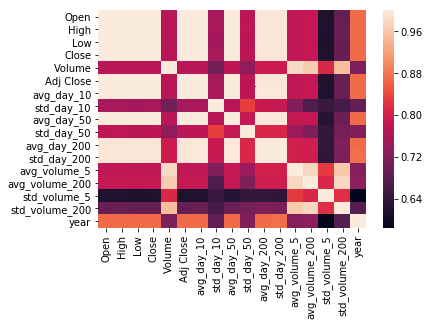

In [125]:
# Generate heatmap of correlation matrix to see if there is duplicate information
corr_matrix = data.corr()
sns.heatmap(corr_matrix)
plt.show()

### Update Model


In [128]:
def feature_transformation(df):
    # Change "Date" column to Pandas Date type which will allow for date comprison with the column
    df['Date'] = pd.to_datetime(data['Date'])
    # Sort dataframe by "Date" ascendingly for later steps
    df = df.sort_values('Date', ascending=True)
    # New columns of rolling average and stardard deviation
    df['avg_day_10'] = df['Close'].rolling(window=10).mean().shift(1)
    df['std_day_10'] = df['Close'].rolling(window=10).std().shift(1)
    df['avg_day_50'] = df['Close'].rolling(window=50).mean().shift(1)
    df['std_day_50'] = df['Close'].rolling(window=50).std().shift(1)
    df['avg_day_200'] = df['Close'].rolling(window=200).mean().shift(1)
    df['std_day_200'] = df['Close'].rolling(window=200).mean().shift(1)
    # Some indicators are NaN. Remove any rows that falls before 1951-1-3
    df = df[df['Date'] > datetime(year=1951, month=1, day=3)]
    # remove any rows with NaN values
    df = df.dropna(axis=0)
    # The ratio between the average price for the past 5 days, and the average price for the past 200 days.
    df['avg_ratio_5_100'] = df['avg_day_10'] / df['avg_day_200']
    # The ratio between the standard deviation for the past 5 days, and the standard deviation for the past days.
    df['std_ratio_5_100'] = df['std_day_10'] / df['std_day_200']
    # The average volume over the past 5 days.
    df['avg_volume_5'] = df['Volume'].rolling(window=5).mean().shift(1)
    # The average volume over the past 200 days.
    df['avg_volume_200'] = df['Volume'].rolling(window=200).mean().shift(1)
    # The ratio between the average volume for the past five days, and the average volume for the past year.
    df['avg_raio_volume_5_200'] = df['avg_volume_5'] / data['avg_volume_200']
    # The standard deviation of the average volume over the past five days.
    df['std_volume_5'] = df['Volume'].rolling(window=5).std().shift(1)
    # The standard deviation of the average volume over the past year.
    df['std_volume_200'] = df['Volume'].rolling(window=200).std().shift()
    # The ratio between the standard deviation of the average volume for the past five days, and the standard deviation 
    # of the average volume for the past year.
    df['std_ratio_volume_5_200'] = df['std_volume_5'] / df['std_volume_200']
    # The year component of the date
    df['year'] = pd.DatetimeIndex(df['Date']).year
    # The month component of the date.
    df['month'] = pd.DatetimeIndex(df['Date']).month
    # The day of week.
    df['dayofweek'] = pd.DatetimeIndex(df['Date']).dayofweek
    # The day component of the date.
    df['day'] = pd.DatetimeIndex(df['Date']).day
    return df

def feature_selection(df):
    # check correlation of columns to 'Close'
    abs_corr_coef_to_close = df.corr()['Close'].abs().sort_values(ascending=False)
    # Drop columns with correlation coefficient < 0.2
    df = df.drop(abs_corr_coef_to_close[abs_corr_coef_to_close < 0.2].index, axis=1)   
    return df

def train_test_eval(df):
    features = ['avg_day_10', 'std_day_10', 'avg_day_50', 'std_day_50', 'avg_day_200', 'std_day_200', 'avg_volume_5', 
                'avg_volume_200', 'std_volume_5', 'std_volume_200', 'year']
    target = ['Close']
    # Split data into two dataframes: 
    train = df[df['Date'] < datetime(year=2013, month=1, day=1)]
    test = df[df['Date'] >= datetime(year=2013, month=1, day=1) ]
    # subset of train and test
    train_target = train[target]
    train_features = train[features]
    test_target = test[target]
    test_features = test[features]
    # LinearRegression model trained and predict
    lr = LinearRegression()
    lr.fit(train_features, train_target)
    predictions = lr.predict(test_features)
    mae = mean_absolute_error(test_target, predictions)
    print(mae)

data = pd.read_csv('sphist.csv')
df = data
transformed_df = feature_transformation(df)
selected_df = feature_selection(transformed_df)
mae = train_test_eval(selected_df)
print(mae)

KeyError: 'avg_volume_200'

### Future Work;

You can also improve the algorithm used significantly. Try other techniques, like a random forest, and see if they perform better.

You can also incorporate outside data, such as the weather in New York City (where most trading happens) the day before, and the amount of Twitter activity around certain stocks.

You can also make the system real-time by writing an automated script to download the latest data when the market closes, and make predictions for the next day.

Finally, you can make the system "higher-resolution". You're currently making daily predictions, but you could make hourly, minute-by-minute, or second by second predictions. This will require obtaining more data, though. You could also make predictions for individual stocks instead of the S&P500.
